<center><img src="https://images.pexels.com/photos/1454360/pexels-photo-1454360.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2" width="400" height="300"></center>

<b><h2><center>Engineering Colleges Case Study</center></h2></b>

## Problem Statement

### Context

Education is fast becoming a very competitive sector with hundreds of institutions to choose from. It is a life-transforming experience for any student and it has to be a thoughtful decision. There are ranking agencies that do a survey of all the colleges to provide more insights to students. Agency RankForYou wants to leverage this year's survey to roll out an editorial article in leading newspapers, on the state of engineering education in the country. Head of PR (Public Relations) comes to you, the data scientist working at RankForYou, and asks you to come up with evidence-based insights for that article.

### Objective

As a data scientist working at RankForYou, you have been asked to identify the different types of engineering colleges in the country to better understand the state of affairs. The key questions that need to be answered are:
- How many different types (clusters/segments) of colleges can be found from the data?
- How do these different groups of colleges differ from each other?
- Do you get slightly different solutions from two different techniques? How would you explain the difference?


### Data Description

The data contains survey results for 26 engineering colleges. The initial survey data has been summarized into a rating scale of 1-5 for different factors.

**Factor rating index**
 - 1 - Very low
 - 2 - Low
 - 3 - Medium
 - 4 - High
 - 5 - Very high

**Data Dictionary**

 - Engg_College: 26 Engineering colleges with pseudonyms A to Z
 - Teaching: Quality of teaching at the engineering college
 - Fees: Fees at the engineering college
 - Placements: Job placements after a student graduates from the engineering college
 - Internship: Student Internships at the engineering college
 - Infrastructure: Infrastructure of the engineering college

## Importing necessary libraries

In [ ]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Reading the Dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# loading the dataset
data = pd.read_csv("/content/drive/MyDrive/data science /hull online/Ailead/ML /Unsupervise learning /Engineering_Colleges.csv")

## Overview of Data preprocessing set

The initial steps to get an overview of any dataset is to:
- observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
- get information about the number of rows and columns in the dataset
- find out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected.
- check the statistical summary of the dataset to get an overview of the numerical columns of the data

### Checking the shape of the dataset

In [ ]:
data.shape

(26, 6)

* The dataset has 26 rows and 7 columns

### Displaying few rows of the dataset

In [ ]:
# viewing a random sample of the dataset

data.sample(5)

,SR_NO,Engg_College,Teaching,Fees,Placements,Infrastructure
18,19,S,3,5,4,3
7,8,H,4,4,5,5
17,18,R,3,4,4,3
19,20,T,3,5,3,3
1,2,B,4,2,5,3


### Creating a copy of original data

In [ ]:
# copying the data to another variable to avoid any changes to original data

df = data.copy()

In [ ]:
# dropping the serial no. column as it does not provide any information

df.drop("SR_NO", axis = 1, inplace=True)

### Checking the data types of the columns for the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Engg_College    26 non-null     object
 1   Teaching        26 non-null     int64 
 2   Fees            26 non-null     int64 
 3   Placements      26 non-null     int64 
 4   Infrastructure  26 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 1.1+ KB


**Observations**

- *Engg_College* is a categorical variable with 26 levels that indicate each college's name.
- The 5 rating variables are of type *int* (integer).

### Statistical summary of the dataset

In [ ]:

df.describe()

,Teaching,Fees,Placements,Infrastructure
count,26.000000,26.000000,26.000000,26.000000
mean,2.807692,3.576923,2.884615,3.384615
std,1.132051,1.331858,1.531716,1.298520
min,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.250000,1.250000,3.000000
50%,3.000000,4.000000,3.000000,3.000000
75%,3.000000,5.000000,4.000000,4.750000
max,5.000000,5.000000,5.000000,5.000000


**Observations**

- The median value of fees is 4, indicating that most of the engineering colleges have high fees.
- The mean and median of other ratings lie between 2 and 3, except the mean infrastructure rating.

### Checking for missing values

In [ ]:
# checking for missing values

df.isnull().sum()

Engg_College      0
Teaching          0
Fees              0
Placements        0
Infrastructure    0
dtype: int64

- There are no missing values in our data

## Exploratory Data Analysis

In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None, title = None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage
    plt.title(title)
    plt.show()  # show the plot

### Univariate Analysis

In [ ]:
# select the numerical features as a list of numerical columns
# num_col = df.select_dtypes(include= number).columns.tolist()
# include= number == (include= np.number)
num_col = df.select_dtypes(include= np.number).columns.tolist()

num_col

['Teaching', 'Fees', 'Placements', 'Infrastructure']

<ipython-input-30-9e54a4cfdff9>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


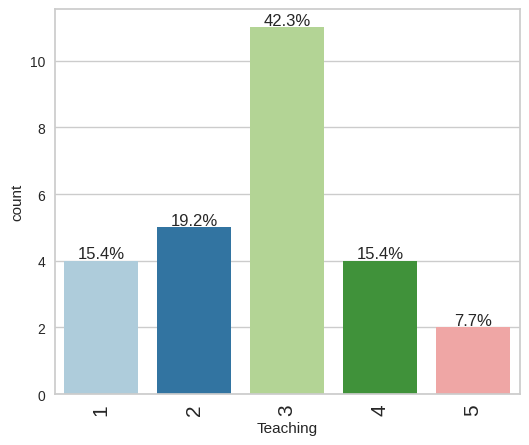

<ipython-input-30-9e54a4cfdff9>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


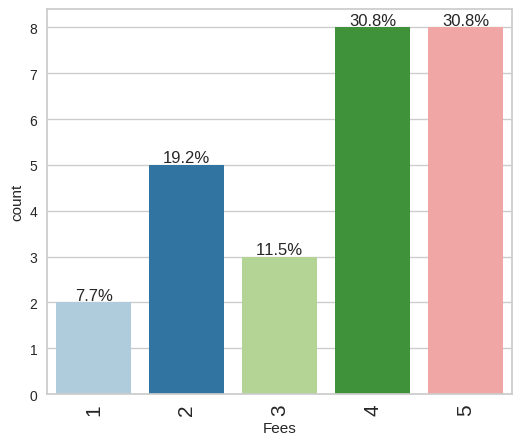

<ipython-input-30-9e54a4cfdff9>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


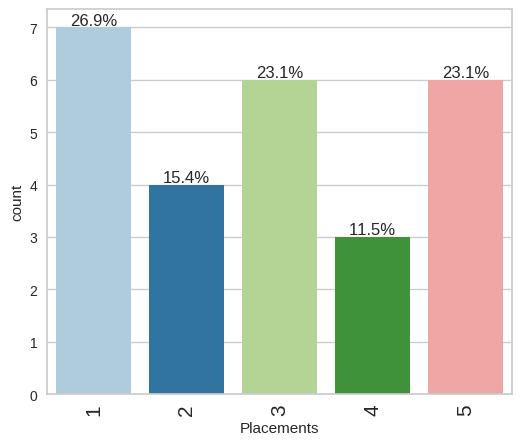

<ipython-input-30-9e54a4cfdff9>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


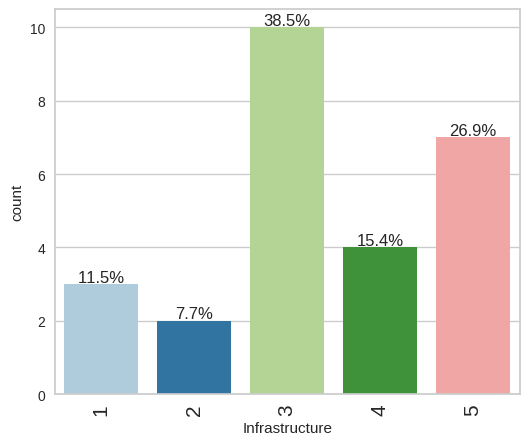

In [ ]:
# loop through each column and create a bar plot for each feature
#
for col in num_col: # features = column  name
    labeled_barplot(data = df, feature=col, perc=True)

**Observations**

- More than 70% of the colleges have a rating of 3 or more for placements.
- More than 80% of the colleges have a rating of 3 or more for infrastructure.
- More than 60% of the colleges have a rating of 3 or more for teaching.

### Bivariate Analsysis

**Let's check for correlations.**

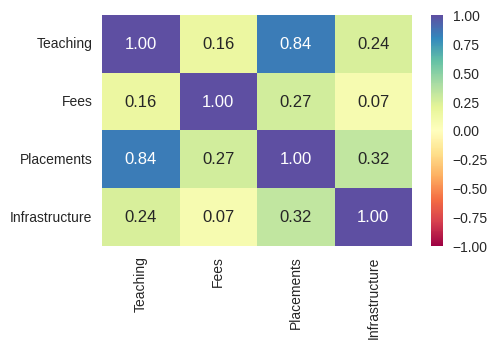

In [ ]:
 # num_col = numerical column in our data set
num_data = df[num_col]

cor = num_data.corr()

plt.figure(figsize=(5, 3))
sns.heatmap(cor, vmin = -1, vmax = 1, cmap = "Spectral", annot=True, fmt=".2f") # two decimal places
plt.show()

**Observation**

- Rating for teaching is strongly positively correlated with the rating for placements.
- This is obvious because if teaching quality is high, students are more likely to get placements.

### **What is feature scaling?**

Feature scaling is a class of statistical techniques that, as the name implies, scales the features of our data so that they all have a similar range. You'll understand better if we look at an example:

If you have multiple independent variables like age, salary, and height, With their range as (18–100 Years), (25,000–75,000 Euros), and (1–2 Meters) respectively, feature scaling would help them all to be in the same range.

### **Why feature scaling is improtant in Unsupervised Learning?**

Feature scaling is specially relevant in machine learning models that compute some sort of distance metric, like most clustering methods like K-Means.

So, scaling should be done to avoid the problem of one feature dominating over others because the unsupervised learning algorithm uses distance to find the similarity between data points.

### For this case study, we will not scale the features because all of the variables in the data have the same units, which range from 1 to 5.

## K-Means Clustering

### using k_means without setting the number of clusters
- the default number of clusters with k means is 8


#### Choosing optimal number of cluster
#### mean distortion method (similar to the inertia method)
- distortion is what is the cummulative distance between the each of the features in the data set and cluster center

- calulate the cummulative distance between the each of the features in the data set and cluster center using the eculidean distance sum(np.min(cdist(num_data, model.cluster_centers_, "euclidean"), axis=1))  and divided by the number of row in the data (num_data.shape[0])

- sum(np.min(cdist(num_data, model.cluster_centers_, "euclidean"), axis=1))/ num_data.shape[0]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Number of Clusters: 1 	Average Distortion: 2.445161236901436
Number of Clusters: 2 	Average Distortion: 1.8386954425352884
Number of Clusters: 3 	Average Distortion: 1.5663251587239047
Number of Clusters: 4 	Average Distortion: 1.319866756300917
Number of Clusters: 5 	Average Distortion: 1.1702052828266019
Number of Clusters: 6 	Average Distortion: 1.0227348535373915
Number of Clusters: 7 	Average Distortion: 0.8865332197832502
Number of Clusters: 8 	Average Distortion: 0.7536430520826071


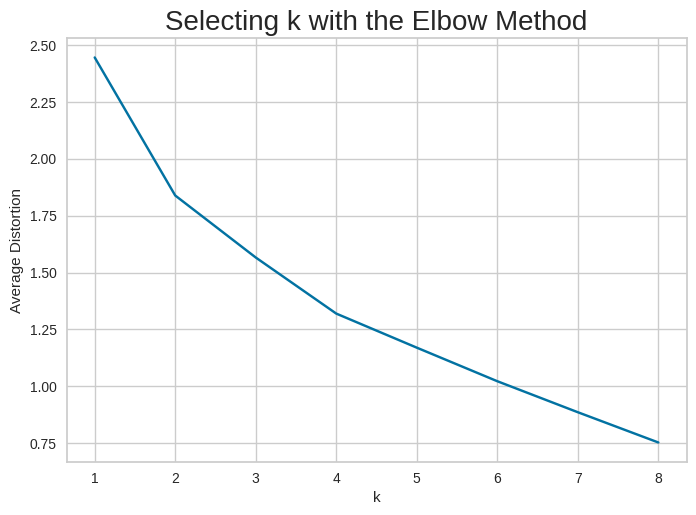

In [ ]:
# Define the range of clusters to try
clusters = range(1, 9)

# Initialize an empty list to store mean distortions for each number of clusters
meanDistortions = []

# Iterate over each number of clusters
for k in clusters:
    # Initialize KMeans with current number of clusters
    model = KMeans(n_clusters=k)

    # Fit KMeans on the data
    model.fit(num_data)

    # Predict clusters for the data
    prediction = model.predict(num_data)

    # Calculate distortion for the current number of clusters
    distortion = (sum(np.min(cdist(num_data, model.cluster_centers_, "euclidean"), axis=1))
                  / num_data.shape[0])

    # Append the calculated distortion to the list
    meanDistortions.append(distortion)

    # Print the number of clusters and its corresponding average distortion
    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

# Plotting the elbow curve
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")  # Label for X-axis
plt.ylabel("Average Distortion")  # Label for y-axis
plt.title("Selecting k with the Elbow Method", fontsize=20)  # Title of the plot
plt.show()  # Display the plot


### using the intertia method to determine the number of clusters

In [ ]:
# Initialize an empty list to store distortions for each number of clusters
distortions = []

# Define the range of clusters to try
K = range(1, 10)

# Iterate over each number of clusters
for k in K:
    # Initialize KMeans with current number of clusters and a fixed random state
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Fit KMeans on the data
    kmeans.fit(num_data)

    # Calculate and append the inertia (sum of squared distances to the nearest centroid) to the list
    distortions.append(kmeans.inertia_)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

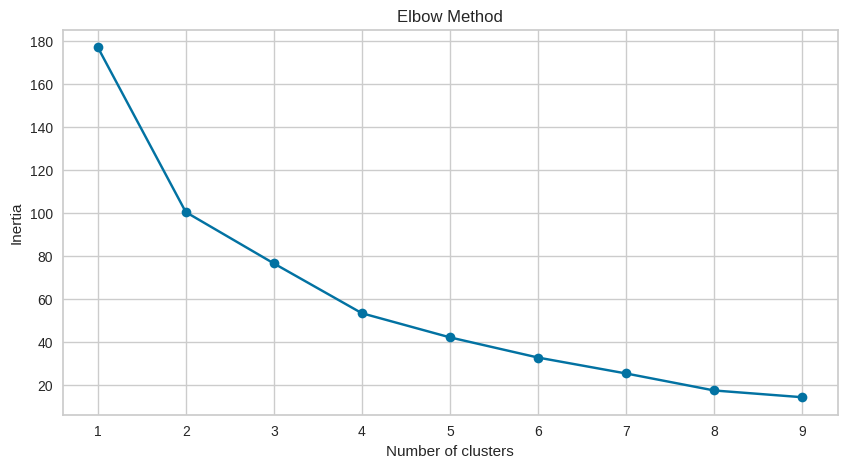

In [ ]:
# Creating a DataFrame with Cluster numbers and their corresponding SSE (sum of squared errors)
frame = pd.DataFrame({"Cluster": range(1,10), "SSE": distortions})

# Setting up the size of the plot
plt.figure(figsize=(10,5))

# Plotting the SSE against the number of clusters
plt.plot(frame["Cluster"], frame["SSE"], marker="o")

# Labeling the axes
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Adding a title to the plot
plt.title('Elbow Method')

# Displaying the plot
plt.show()


**In the above plot, the elbow is seen for K=2 and 4 but if you observe the Average distortion results, there is some drop in distortion at K= 5**

**) How do we determine the optimal K value when the elbows point is not clear but observed at 3 or more K values from the elbow curve?**

**To make a better decision about the number of clusters, we can look at the silhouette score for different K values.**

### What is silhouette score?

Silhouette score is one of the methods for evaluating the quality of clusters created using clustering algorithms such as K-Means. The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Silhouette score has a range of [-1, 1].

* Silhouette coefficients near +1 indicate that the sample is far away from the neighboring clusters.
* Silhouette score near -1 indicate that those samples might have been assigned to the wrong cluster.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

For n_clusters = 2, silhouette score is 0.38121701144257797
For n_clusters = 3, silhouette score is 0.4288415910208104
For n_clusters = 4, silhouette score is 0.36154656907517135
For n_clusters = 5, silhouette score is 0.3768337560059902
For n_clusters = 6, silhouette score is 0.3724058078460387
For n_clusters = 7, silhouette score is 0.4213389680738873
For n_clusters = 8, silhouette score is 0.45545926155854705
For n_clusters = 9, silhouette score is 0.42510835718983014


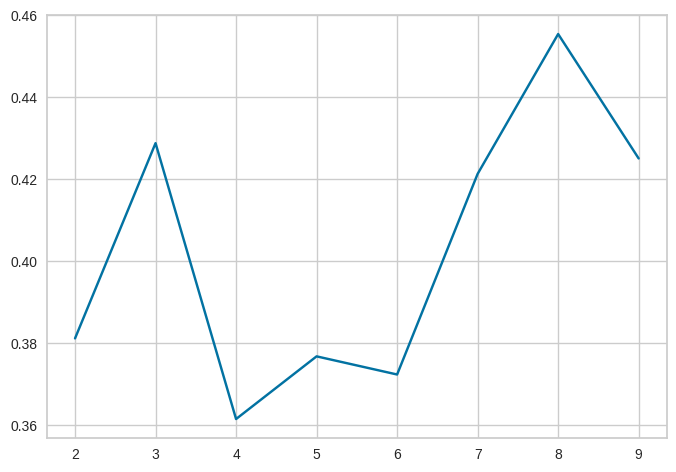

In [ ]:
# Create an empty list to store silhouette scores
sil_score = []

# Create a list of cluster numbers ranging from 2 to 9
cluster_list = list(range(2, 10))

# Iterate over each number of clusters
for n_clusters in cluster_list:
    # Initialize KMeans algorithm with the current number of clusters
    clusterer = KMeans(n_clusters=n_clusters)

    # Predict cluster labels for the data
    preds = clusterer.fit_predict(num_data)

    # Calculate silhouette score for the current number of clusters
    score = silhouette_score(num_data, preds)

    # Append the silhouette score to the list
    sil_score.append(score)

    # Print the silhouette score for the current number of clusters
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

# Plotting silhouette scores against the number of clusters
plt.plot(cluster_list, sil_score)


**From the silhouette scores, it seems that 8 is a good value of k.Let's do deeper investigation for different K values using  SilhouetteVisualizer**

### How to interpret the results of SilhouetteVisualizer?

Below are the points that every cluster needs to satisfy for selecting the optimal K-value.
  - There should be no negative silhouette coefficent value
  - All the clusters should cross the avg silhouette score
  - All the clusters should have the different variations (width)
  - All the clusters should have different silhouette score

**Note**
1. Width of each cluster refers to the size of each cluster. (Number of data points present in each cluster)
2. Horizontal line refers to the Silhouette score of each cluster.
3. Dotted red line is an Average Silhouette score.


- The silhouette score is highest for 8 clusters, which is 0.4555.

- The silhouette scores for 3 clusters (0.4288) and 7 clusters (0.4213) are also relatively high.

### Applying KMeans clustering for k=3

In [ ]:
# Initialize KMeans algorithm with 3 clusters and a fixed random state
kmeans3 = KMeans(n_clusters=3, random_state=0)

# Fit KMeans to the data
kmeans3.fit(num_data)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=0)

In [ ]:
# Access the cluster labels assigned by KMeans to each data point
kmeans3.labels_


array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2,
       2, 0, 0, 1], dtype=int32)

### Another way of determining the cluster lebles

In [ ]:
# label3 = kmeans3.predict(num_data)  == kmeans3.labels_
label3 = kmeans3.predict(num_data)
label3

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2,
       2, 0, 0, 1], dtype=int32)

- These cluster labels can be used to analyze and interpret the clustering results, such as understanding the characteristics of each cluster or visualizing the data points grouped by cluster

In [ ]:
# to check the number of groups
np.unique(kmeans3.labels_)

array([0, 1, 2], dtype=int32)

In [ ]:
# adding kmeans cluster labels to the original dataframe
num_data["Kmeans_clusters"] = kmeans3.labels_

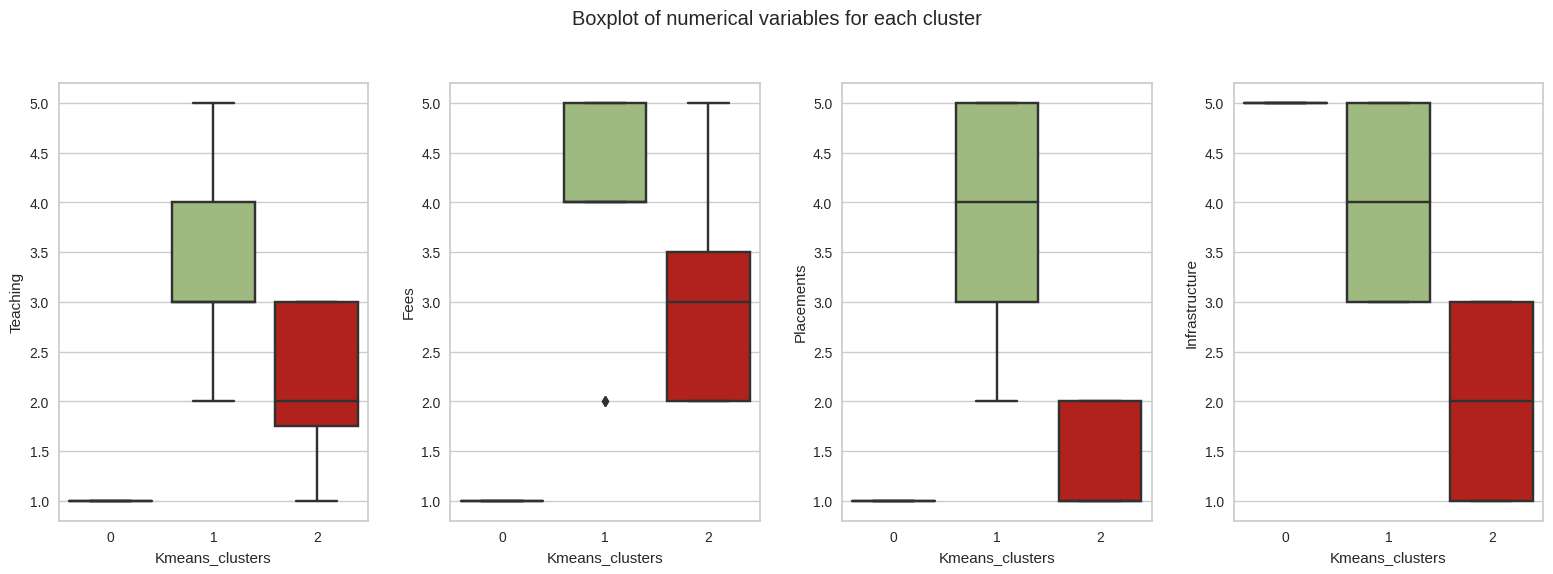

In [ ]:
"""
select axis (ax=axes[ii])
select the list (num_col) of the features by passing the counter 'num_col[counte]'
and use the selecet the data set corresponind to feature 'num_data[num_col[counter]'
 and plot againt the cluster
"""
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(4): # 4 corresponding to the number of feature in our data
    sns.boxplot(ax=axes[ii], y=num_data[num_col[counter]], x=num_data["Kmeans_clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)# is to make sure the label or features does not overlap

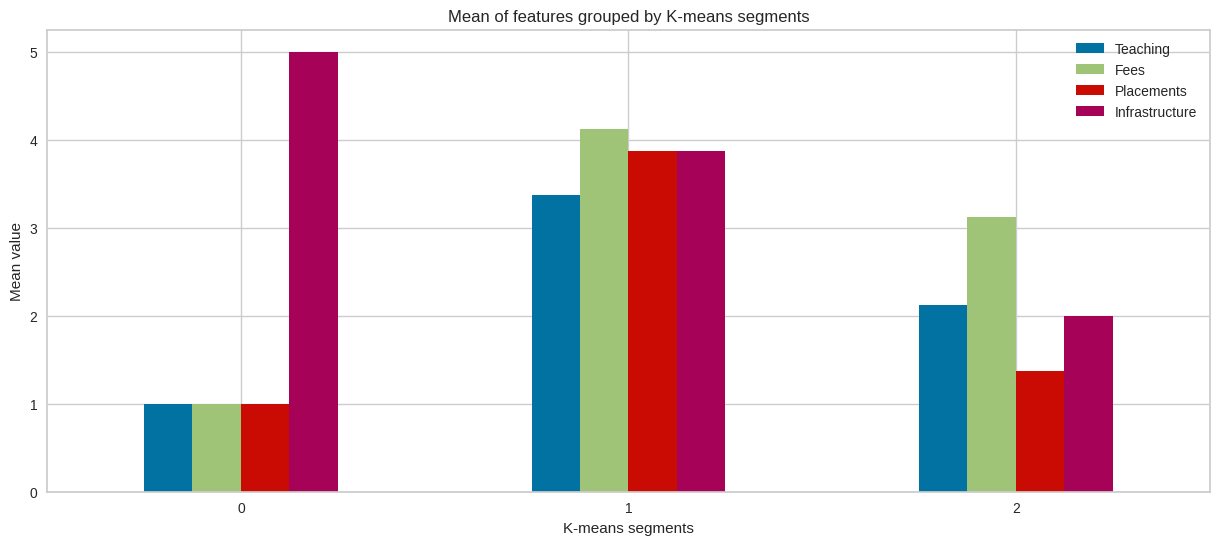

In [ ]:
# Group the data by K-means clusters and calculate the mean of each feature
grouped_means = num_data.groupby("Kmeans_clusters").mean()

# Plot the mean values for each feature grouped by K-means clusters
grouped_means.plot.bar(figsize=(15, 6))
plt.title("Mean of features grouped by K-means segments")
plt.xlabel("K-means segments")
plt.ylabel("Mean value")
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()


### Insights

- **Cluster 0**:
    - Teaching ratings are low.
    - Fees range from low to moderate for colleges in this cluster.
    - Placement and ratings are very low.
    - Infrastructure ratings are low  to moderate.


- **Cluster 1**:
    - Teaching ratings is high.
    - Fees ratings for colleges in this cluster are high.
    - Placement ratings are high.
    - Infrastructure ratings are high.




- **Cluster 2**:
    - Teaching ratings are moderate to high.
    - Fees ratings for colleges in this cluster are moderate.
    - Placement ratings are moderate.
    - Infrastructure ratings are moderate.

### Business Recommendations

- **Cluster 0**: These are Tier 3 colleges with low fees and very poor infrastructure, but they do not offer proper value-for-money in terms of teaching and placements. **Colleges in this cluster need to significantly invest in their teaching, concentrate more on onboarding better faculty, and secure tie-ups with corporates to improve placement opportunities.**


- **Cluster 1**: These are Tier 1 colleges with excellent teaching, infrastructure, and placements while maintaining high fees. **Corporates looking for the best candidates can approach this cluster for placements.**


- **Cluster 2**: These are Tier 2 colleges with decent teaching, infrastructure, and placement while maintaining a relatively moderate fee. **These colleges will need some investment in their teaching and infrastructure, which will help propel them to Tier 1 status.**
